# TelecomX LATAM — Parte 2: Modelado de Churn

**Objetivo:** preparar datos para modelado, realizar selección de variables, entrenar y evaluar múltiples clasificadores, interpretar importancia de variables y concluir con implicaciones estratégicas.


In [1]:
# ==== Setup ====
import json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import pointbiserialr, chi2_contingency

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
RANDOM_STATE = 42
DATA_JSON = Path("/content/TelecomX_Data.json")


carga y limpieza

In [2]:
def load_and_flatten(json_path: Path) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return pd.json_normalize(data, sep=".")

RENAME_MAP = {
    "customer.gender": "gender",
    "customer.SeniorCitizen": "SeniorCitizen",
    "customer.Partner": "Partner",
    "customer.Dependents": "Dependents",
    "customer.tenure": "tenure",
    "phone.PhoneService": "PhoneService",
    "phone.MultipleLines": "MultipleLines",
    "internet.InternetService": "InternetService",
    "internet.OnlineSecurity": "OnlineSecurity",
    "internet.OnlineBackup": "OnlineBackup",
    "internet.DeviceProtection": "DeviceProtection",
    "internet.TechSupport": "TechSupport",
    "internet.StreamingTV": "StreamingTV",
    "internet.StreamingMovies": "StreamingMovies",
    "account.Contract": "Contract",
    "account.PaperlessBilling": "PaperlessBilling",
    "account.PaymentMethod": "PaymentMethod",
    "account.Charges.Monthly": "Charges.Monthly",
    "account.Charges.Total": "Charges.Total",
}

def build_clean_df():
    raw = load_and_flatten(DATA_JSON)
    df = raw.rename(columns=RENAME_MAP).copy()

    # Tipificación básica
    df["Charges.Monthly"] = pd.to_numeric(df["Charges.Monthly"], errors="coerce")
    df["Charges.Total"] = pd.to_numeric(df["Charges.Total"], errors="coerce")
    df["SeniorCitizen"] = pd.to_numeric(df["SeniorCitizen"], errors="coerce").astype("Int64")
    df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")

    # Normalización Yes/No y "No internet/phone service"
    def norm_yn(s):
        s = s.fillna("No").astype(str)
        return s.replace({"YES":"Yes","yes":"Yes","NO":"No","no":"No"})
    for c in ["Partner","Dependents","PhoneService","PaperlessBilling"]:
        if c in df: df[c] = norm_yn(df[c])

    def collapse(s, token):
        s = s.fillna("No").astype(str)
        return s.replace({token:"No"})
    if "MultipleLines" in df: df["MultipleLines"] = collapse(df["MultipleLines"], "No phone service")
    for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]:
        if c in df: df[c] = collapse(df[c], "No internet service")

    # Target binario
    df["Churn"] = df["Churn"].replace({"": np.nan})
    df = df.dropna(subset=["Churn"]).copy()
    df["y"] = df["Churn"].map({"Yes":1, "No":0}).astype(int)

    return df

# Si ya viene de la parte 1, úsalo; si no, construye.
if "df_labeled" in globals():
    df = df_labeled.copy()
    if "y" not in df:
        df["y"] = df["Churn"].map({"Yes":1, "No":0}).astype(int)
else:
    df = build_clean_df()

print(df.shape)
display(df.head())
print("Churn rate:", df["y"].mean().round(4))


(7043, 22)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,y
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1


Churn rate: 0.2654


Preparación para modelado

In [3]:
# Variables numéricas y categóricas
num_cols = [c for c in ["tenure","Charges.Monthly","Charges.Total","SeniorCitizen"] if c in df.columns]
cat_cols = [c for c in [
    "gender","Partner","Dependents","PhoneService","MultipleLines",
    "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
    "StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod"
] if c in df.columns]

X = df[num_cols + cat_cols].copy()
y = df["y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# OneHotEncoder denso para poder calcular MI y coeficientes
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Ajuste de preprocesador para obtener nombres de características
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
print("Total de features modeladas:", len(feature_names))


Total de features modeladas: 38


Correlacion y seleccion de variables

In [4]:
# --- Correlación (numéricas ↔ churn) con point-biserial
corr_rows = []
for c in num_cols:
    series = pd.to_numeric(X_train[c], errors="coerce").fillna(X_train[c].median())
    r, p = pointbiserialr(series, y_train)
    corr_rows.append((c, r, p))
corr_df = pd.DataFrame(corr_rows, columns=["feature","r_pointbiserial","p_value"]).sort_values("r_pointbiserial", ascending=False)
display(corr_df)

# --- Asociación (categóricas ↔ churn) con Cramér's V corregido
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / max(1e-9, min((kcorr-1), (rcorr-1))))

cr_rows = []
for c in cat_cols:
    v = cramers_v(X_train[c], y_train)
    cr_rows.append((c, v))
cramers_df = pd.DataFrame(cr_rows, columns=["feature","cramers_v"]).sort_values("cramers_v", ascending=False)
display(cramers_df)

# --- Selección estadística: Mutual Information sobre matriz ya preprocesada
Xtr_enc = preprocessor.transform(X_train)
mi = mutual_info_classif(Xtr_enc, y_train, random_state=RANDOM_STATE, discrete_features="auto")
mi_df = pd.DataFrame({"feature": feature_names, "MI": mi}).sort_values("MI", ascending=False)
display(mi_df.head(20))


,feature,r_pointbiserial,p_value
1,Charges.Monthly,0.188884,2.082231e-46
3,SeniorCitizen,0.153134,6.578679e-31
2,Charges.Total,-0.201819,7.311576e-53
0,tenure,-0.351948,5.701454e-164


,feature,cramers_v
12,Contract,0.412085
5,InternetService,0.317931
14,PaymentMethod,0.305098
13,PaperlessBilling,0.191838
9,TechSupport,0.170212
6,OnlineSecurity,0.167618
2,Dependents,0.157055
1,Partner,0.151056
7,OnlineBackup,0.084906
8,DeviceProtection,0.065912


,feature,MI
29,cat__Contract_Month-to-month,0.095713
31,cat__Contract_Two year,0.073338
0,num__tenure,0.067252
36,cat__PaymentMethod_Electronic check,0.051246
15,cat__InternetService_Fiber optic,0.049639
1,num__Charges.Monthly,0.048899
2,num__Charges.Total,0.048820
16,cat__InternetService_No,0.034751
18,cat__OnlineSecurity_Yes,0.023637
8,cat__Dependents_No,0.020388


Definicion de modelos y cross validation

In [5]:
# Pipelines de modelado
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE))
])

rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1
    ))
])

models = {
    "LogisticRegression": log_reg,
    "RandomForest": rf
}

scoring = {
    "accuracy":"accuracy",
    "precision":"precision",
    "recall":"recall",
    "f1":"f1",
    "roc_auc":"roc_auc"
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
for name, pipe in models.items():
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_results[name] = {k: (v.mean(), v.std()) for k, v in res.items() if k.startswith("test_")}
pd.DataFrame(cv_results).T


,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
LogisticRegression,"(0.7484878668433934, 0.01361356871644042)","(0.517192401303101, 0.016726945779169656)","(0.8053511705685619, 0.013444649660362386)","(0.6297330852232924, 0.014337642837265544)","(0.8446967814778679, 0.01692215797326589)"
RandomForest,"(0.7864731497665095, 0.010531327077794516)","(0.5949962373583407, 0.019123162755924353)","(0.6120401337792643, 0.027981940686758393)","(0.6032035763227713, 0.02134669197488634)","(0.8346103958989488, 0.017981091607203285)"


Entrenamiento y evaluacion

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.740241,0.506897,0.786096,0.616352,0.843363
RandomForest,0.781405,0.582915,0.620321,0.601036,0.836869



=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.903     0.724     0.804      1035
           1      0.507     0.786     0.616       374

    accuracy                          0.740      1409
   macro avg      0.705     0.755     0.710      1409
weighted avg      0.798     0.740     0.754      1409



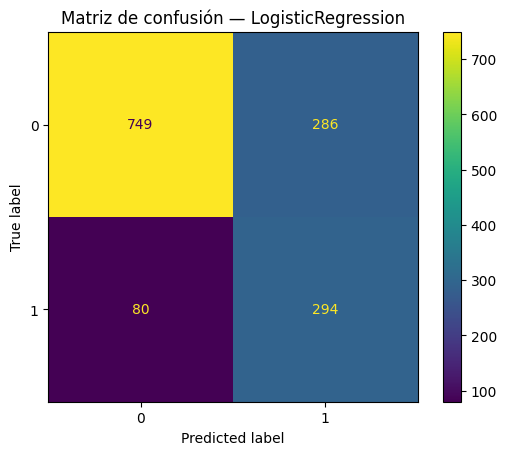


=== RandomForest ===
              precision    recall  f1-score   support

           0      0.860     0.840     0.849      1035
           1      0.583     0.620     0.601       374

    accuracy                          0.781      1409
   macro avg      0.721     0.730     0.725      1409
weighted avg      0.786     0.781     0.784      1409



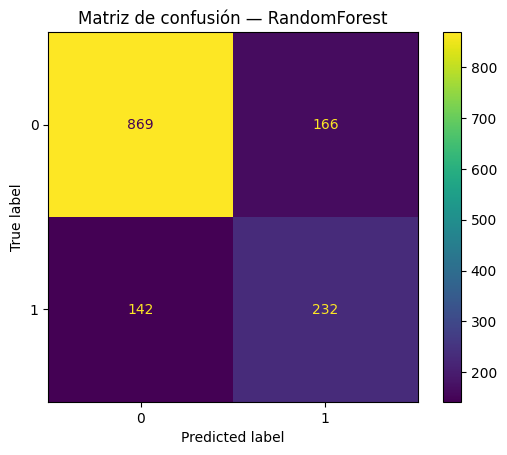

<Figure size 640x480 with 0 Axes>

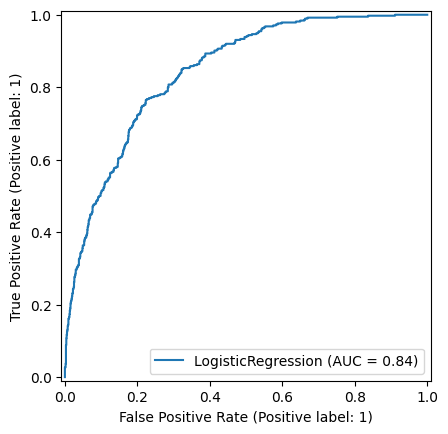

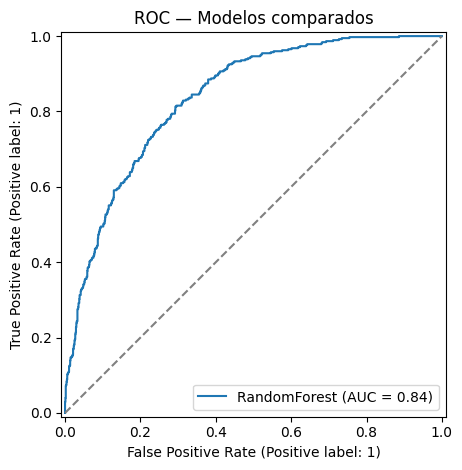

In [6]:
fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

eval_rows = []
for name, pipe in fitted.items():
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1]
    row = {
        "model": name,
        "accuracy": accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred),
        "recall": recall_score(y_test, pred),
        "f1": f1_score(y_test, pred),
        "roc_auc": roc_auc_score(y_test, proba)
    }
    eval_rows.append(row)

eval_df = pd.DataFrame(eval_rows).set_index("model").sort_values("roc_auc", ascending=False)
display(eval_df)

# Reportes y matrices de confusión
for name, pipe in fitted.items():
    print(f"\n=== {name} ===")
    pred = pipe.predict(X_test)
    print(classification_report(y_test, pred, digits=3))
    cm = confusion_matrix(y_test, pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matriz de confusión — {name}")
    plt.show()

# Curvas ROC
plt.figure()
for name, pipe in fitted.items():
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
plt.title("ROC — Modelos comparados")
plt.plot([0,1],[0,1],"--", color="gray")
plt.tight_layout()
plt.show()


Interpretabilidad

In [8]:
# Nombres finales de variables (tras OHE + escalado)
feat_names = feature_names  # del preprocessor fit en la Sección 3

# --- Logistic Regression: coeficientes
lr = fitted["LogisticRegression"].named_steps["model"]
# La salida del preprocesador no altera el orden de feature_names
lr_coefs = pd.Series(lr.coef_[0], index=feat_names).sort_values(key=np.abs, ascending=False)
print("Top 20 | Coeficientes (magnitud):")
display(lr_coefs.head(20))

# --- RandomForest: importancias
rf_model = fitted["RandomForest"].named_steps["model"]
rf_imps = pd.Series(rf_model.feature_importances_, index=feat_names).sort_values(ascending=False)
print("Top 20 | Importancia (RandomForest):")
display(rf_imps.head(20))


# --- Permutation Importance con Pipeline
best_model_name = eval_df.index[0]
best_pipe = fitted[best_model_name]

perm = permutation_importance(
    best_pipe, X_test, y_test,
    n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1
)

# Usamos los nombres de las columnas originales de X_test
orig_names = X_test.columns
assert len(perm.importances_mean) == len(orig_names), \
    f"Esperaba {len(orig_names)} importancias, obtuve {len(perm.importances_mean)}."

perm_imp_orig = pd.Series(perm.importances_mean, index=orig_names)\
                  .sort_values(ascending=False)

print(f"Top 20 | Permutation Importance (entradas) — {best_model_name}")
display(perm_imp_orig.head(20))



Top 20 | Coeficientes (magnitud):


,0
num__tenure,-1.269487
cat__InternetService_No,-0.947119
cat__InternetService_Fiber optic,0.812263
cat__Contract_Two year,-0.754865
cat__Contract_Month-to-month,0.661099
num__Charges.Total,0.593451
cat__PhoneService_Yes,-0.287501
cat__PaymentMethod_Electronic check,0.271453
cat__TechSupport_Yes,-0.260667
cat__PaperlessBilling_No,-0.243343


Top 20 | Importancia (RandomForest):


,0
num__Charges.Total,0.135045
num__tenure,0.131944
cat__Contract_Month-to-month,0.122442
num__Charges.Monthly,0.115763
cat__Contract_Two year,0.053275
cat__InternetService_Fiber optic,0.040819
cat__PaymentMethod_Electronic check,0.034615
cat__InternetService_No,0.027109
cat__Contract_One year,0.017855
cat__PaperlessBilling_Yes,0.016502


Top 20 | Permutation Importance (entradas) — LogisticRegression


,0
tenure,0.087816
InternetService,0.035250
Charges.Total,0.014147
TechSupport,0.002366
Contract,0.002271
DeviceProtection,0.001230
PaymentMethod,0.000757
Partner,-0.000095
SeniorCitizen,-0.000426
gender,-0.000757
